In [3]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [5]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

# visualization
def show_result2group(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neg',
                   'False Pos', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(2,2)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def show_result5group(ypred: np.array, ytarget: np.array) -> None:
    label = [1,2,3,4,5][::-1]
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'True Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'True Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'True Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(5, 5)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Pre-Process</h3>
</center>

Goals
- Try more extensive features (CBOW & BERT)

In [6]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [7]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [8]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

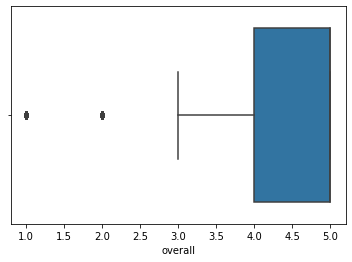

In [9]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

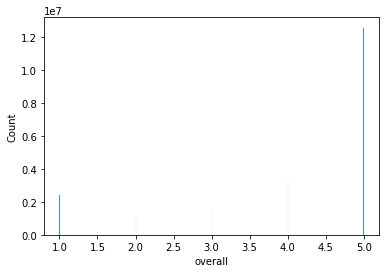

In [10]:
sns.histplot(df['overall'])

In [11]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [12]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [13]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [14]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [15]:
# filter to only get 1 & 5 output
dfdata = dfdata[dfdata['overall'].apply(lambda x: x in (1, 5))]

In [16]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [17]:
dfdataMain.shape

(500000, 2)

In [18]:
# for training & testing
target_n = 480 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [19]:
# for validation
target_n = 48 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [20]:
# for validation training & testing
target_n = 45 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

<AxesSubplot:xlabel='overall', ylabel='Count'>

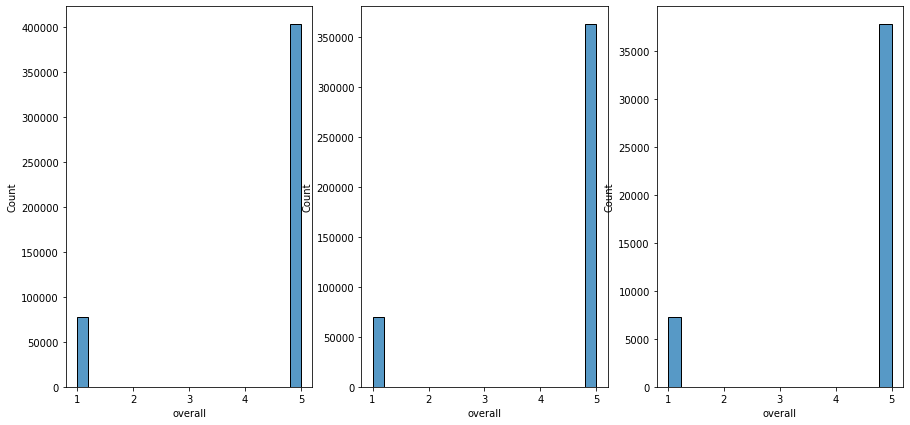

In [21]:
fig, axes = plt.subplots(figsize=(15,7), nrows=1, ncols=3)
sns.histplot(dfdataTrain['overall'], ax=axes[0])
sns.histplot(dfdataTrainSub['overall'], ax=axes[1])
sns.histplot(dfdataValidTrain['overall'], ax=axes[2])

In [22]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

465613128

In [23]:
# validation for processing

In [24]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

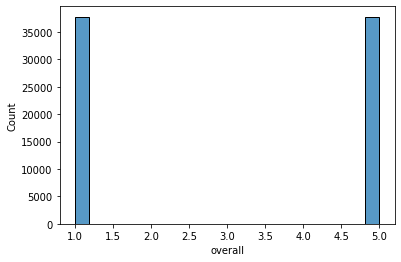

In [25]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [26]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

<center>
    <h3>Test Function</h3>
</center>

In [27]:
# generate embedding model

In [28]:
import gensim
import multiprocessing
cores = multiprocessing.cpu_count()

In [29]:
# text processing
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
tdf1['lenW'] = tdf1['reviewText'].apply(lambda x: len(x))
tdf2['lenW'] = tdf2['reviewText'].apply(lambda x: len(x))

In [30]:
training_corpus = [x.split() for x in tdf1['reviewText'].tolist()]

In [31]:
# train w2v model (skipgram), it will be use to embedded the text

w2v_model = gensim.models.word2vec.Word2Vec(training_corpus, epochs=30, vector_size=300, sample=6e-5,alpha=0.03, min_alpha=0.0007, window=8, min_count=5, workers=cores-1)
w2v_model.init_sims(replace=True)

In [32]:
# see sample
w2v_model.wv['great__JJ__1'].shape

(300,)

In [33]:
# closest word
w2v_model.wv.most_similar('great__JJ__1')

[('good__JJ__1', 0.7691408395767212),
 ('awesome__JJ__1', 0.7178188562393188),
 ('excellent__JJ__1', 0.7172877788543701),
 ('nice__JJ__1', 0.6827214956283569),
 ('perfect__JJ__1', 0.6808541417121887),
 ('for__IN__1', 0.6384673118591309),
 ('fantastic__JJ__1', 0.6373404264450073),
 ('this__DT__1', 0.623563289642334),
 ('the__DT__1', 0.6181455850601196),
 ('amazing__JJ__1', 0.617005467414856)]

---

In [34]:
# generate matrix that can map id to vector

In [35]:
# create dict
from tensorflow.keras import models, layers, preprocessing as kprocessing

tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN")
tokenizer.fit_on_texts(training_corpus)
dic_vocabulary = tokenizer.word_index
dic_vocabulary

{'NaN': 1,
 '.__.__2': 2,
 '.__.__3': 3,
 'the__dt__2': 4,
 'the__dt__3': 5,
 '.__.__5': 6,
 'the__dt__1': 7,
 '.__.__4': 8,
 '.__.__1': 9,
 'the__dt__4': 10,
 ',__,__2': 11,
 ',__,__3': 12,
 'it__prp__2': 13,
 'and__cc__2': 14,
 'and__cc__3': 15,
 'to__to__3': 16,
 'i__nn__1': 17,
 ',__,__1': 18,
 'it__prp__3': 19,
 'to__to__2': 20,
 'it__prp__1': 21,
 ',__,__4': 22,
 'it__prp__4': 23,
 'to__to__4': 24,
 'a__dt__1': 25,
 'and__cc__1': 26,
 'and__cc__4': 27,
 'this__dt__1': 28,
 'a__dt__4': 29,
 'to__to__1': 30,
 'a__dt__3': 31,
 'a__dt__2': 32,
 'i__nn__2': 33,
 'i__nn__3': 34,
 'for__in__1': 35,
 'i__nn__4': 36,
 'this__dt__4': 37,
 'is__vbz__1': 38,
 'my__prp$__1': 39,
 'is__vbz__3': 40,
 'of__in__1': 41,
 'is__vbz__2': 42,
 'is__vbz__4': 43,
 'for__in__4': 44,
 'of__in__2': 45,
 'of__in__3': 46,
 'my__prp$__2': 47,
 'of__in__4': 48,
 'for__in__3': 49,
 'for__in__2': 50,
 'my__prp$__3': 51,
 'was__vbd__1': 52,
 'not__rb__1': 53,
 'not__rb__4': 54,
 'this__dt__3': 55,
 'not__rb__3': 

In [36]:
# map text corpus to id
lst_text2seq= tokenizer.texts_to_sequences(training_corpus)
lst_text2seq

[[7,
  7917,
  38,
  8069,
  26,
  4,
  329,
  42,
  270,
  227,
  31,
  272,
  4290,
  16,
  19,
  27,
  43,
  30833,
  943,
  60686],
 [238,
  104,
  20830,
  9,
  12719,
  60687,
  1806,
  394,
  53,
  1339,
  188,
  13,
  42,
  1082,
  187,
  188,
  13,
  42,
  5220,
  12,
  82,
  5,
  941,
  1818,
  74,
  5,
  24466,
  16612,
  4594,
  1123,
  10,
  1473,
  17474,
  120,
  23,
  43,
  8070,
  6187,
  6],
 [6870],
 [78, 96, 92, 313, 214, 11, 2969, 272, 12, 15, 51, 5370, 2442, 23, 59],
 [78, 3319, 50, 31, 206, 258, 6],
 [2041,
  9,
  21,
  3151,
  39,
  44709,
  1944,
  267,
  25,
  9076,
  9,
  7111,
  513,
  149,
  20831,
  790,
  256,
  2,
  2026,
  13,
  105,
  14,
  19,
  1150,
  272,
  3,
  55,
  40,
  5,
  9942,
  147,
  34,
  544,
  2119,
  8,
  3700,
  29,
  1776,
  48,
  967,
  8,
  1967,
  280,
  6],
 [28,
  38,
  25,
  78,
  1866,
  9,
  94,
  384,
  30,
  1363,
  26,
  7,
  1240,
  313,
  4249,
  2,
  4,
  10421,
  42,
  165,
  6781,
  14,
  4,
  15214,
  63,
  4,
  503

In [37]:
# padding sequence (taken words up to 45), this will be example of embedding matrix
# we will use this output to map to the embedding vector
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=45, padding="post", truncating="post")
X_train

array([[    7,  7917,    38, ...,     0,     0,     0],
       [  238,   104, 20830, ...,     0,     0,     0],
       [ 6870,     0,     0, ...,     0,     0,     0],
       ...,
       [  993,    25,  6176, ...,    13,    61,   547],
       [ 5517,    35,    39, ...,     0,     0,     0],
       [   17,   540,   384, ...,     0,     0,     0]])

In [38]:
X_train.shape

(75516, 45)

---

In [39]:
# create the embedding matrix for input of model

In [40]:
embeddings = np.zeros((len(dic_vocabulary)+1, 300)) # size of vocab size * dimensions size
for word, idx in dic_vocabulary.items():
    # update index of embeddings matrix with its vector
    if word in w2v_model.wv:
        embeddings[idx] = w2v_model.wv[word]

In [41]:
embeddings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08190196, -0.03836343,  0.05074503, ..., -0.02633432,
        -0.06210024,  0.02232217],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

---

In [42]:
# test create embedding torch layer

In [43]:
import torch

In [44]:

embeddingsTorch = torch.from_numpy(embeddings)

embeddingLayer = torch.nn.Embedding.from_pretrained(embeddingsTorch)

embeddingLayer(torch.LongTensor([3,0]))

tensor([[-6.3462e-02, -2.8572e-02, -9.7504e-03, -2.7153e-02,  1.9868e-02,
          9.4603e-02,  1.0797e-01, -1.0232e-01, -5.5264e-02,  3.6181e-02,
          2.0844e-02,  5.1470e-02, -5.9677e-02, -7.8000e-02,  1.1345e-01,
          1.0615e-01, -3.0922e-02, -4.0667e-02, -3.6985e-02,  6.4612e-02,
          6.5446e-02, -5.4110e-02,  3.0082e-02, -3.9110e-02, -4.3961e-02,
         -9.7993e-03,  2.0308e-02, -3.5673e-03,  1.0301e-01,  4.2864e-02,
          9.0977e-02,  2.4857e-02,  2.0908e-02,  7.7251e-02, -6.3302e-02,
          1.0338e-02,  2.9750e-02,  2.2072e-03, -2.3121e-02,  5.4973e-02,
          5.4262e-02, -2.1998e-02,  5.9053e-04,  5.4012e-02, -6.6425e-03,
         -6.8406e-02,  8.3961e-02,  3.2121e-03,  5.8198e-02, -5.7440e-02,
          5.0008e-03, -6.4627e-03, -3.2245e-02,  7.2024e-02,  8.0767e-02,
         -1.1210e-01, -2.7051e-02,  3.8166e-03,  6.8865e-02,  7.1945e-02,
          2.9851e-02, -2.7925e-02,  4.8475e-02, -7.4135e-02, -1.6021e-01,
          8.7227e-02, -6.3134e-02,  6.

<center>
    <h3>New Function</h3>
</center>

In [92]:
import gensim
import multiprocessing
from tensorflow.keras import models, layers, preprocessing as kprocessing


def skipGram(training_corpus: list) -> None:
    """
    This model will be use to embedded the words

    training_corpus: list of list of words, i.e list of split sentences
    """
    
    w2v_model = gensim.models.word2vec.Word2Vec(
        training_corpus, 
        epochs=100, 
        vector_size=300, 
        sample=6e-5,
        alpha=0.001, 
        min_alpha=0.0007, 
        window=15, 
        min_count=5,
        workers=multiprocessing.cpu_count()-1)
    w2v_model.init_sims(replace=True)

    return w2v_model

def textTokenizer(training_corpus: list) -> None:
    """
    This model will be use to tokenized the text and get the id

    training_corpus: list of list of words, i.e list of split sentences
    """

    tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN")
    tokenizer.fit_on_texts(training_corpus)

    return tokenizer

def textToIDs(tokenizer: kprocessing.text.Tokenizer, training_corpus: list) -> None:
    """
    This function will be use to convert texts to id & added padding

    tokenizer: needs to be kprocessing.text.Tokenizer object
    training_corpus: list of list of words, i.e list of split sentences
    """

    text2seq= tokenizer.texts_to_sequences(training_corpus)
    data = kprocessing.sequence.pad_sequences(
        text2seq, 
        maxlen=75, 
        padding="post", 
        truncating="post")

    return data

def getEmbeddedData(w2v_model: gensim.models.word2vec.Word2Vec, tokenizer: kprocessing.text.Tokenizer) -> None:
    """
    This function will generate the embedded matrix to map the word id
    
    w2v_model: will be use to get the vector
    tokenizer: will be use to get the corpus mapping dictionary
    """
    
    embeddings = np.zeros((len(dic_vocabulary)+1, w2v_model.wv.vector_size))
    for word, index in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embeddings[index] = w2v_model.wv[word]
    
    return embeddings

<center>
    <h3>NN Layer</h3>
</center>

<div style="white-space:pre-line"> Architecture
Original Input: (75, 500) -> Flattened(75 * 500)
Layer1: {Input: (1, 37500) -> Output: (37500, 500)} = 500 Neurons
Layer2: {Input: (1, 500) -> Output: (1, 100)} = 100 Neurons
Layer2: {Input: (1, 100) -> Output: (1, 50)} = 50 Neurons
Output: {Input: (1m 2) -> Output: (2, )} = 2 Neurons
</div>

In [102]:
import torch
from torchinfo import summary
import torchtext
import torchvision
from torch.utils.data import Dataset, DataLoader


class NeuralNetwork(torch.nn.Module):
    def __init__(self, embeddings, dropout_rate):
        super(NeuralNetwork, self).__init__()
        
        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(embeddings)).float()
        # flatten layer
        self.flatten = torch.nn.Flatten(1)
        # fully-connected layer 1
        self.nn1 = torch.nn.Linear(22500, 100)
        # full-connected layer 2
        self.nn2 = torch.nn.Linear(100, 45)
        # output layer
        self.nn3 = torch.nn.Linear(45, 2)
        
        # dropout rate
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.nn1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn3(x)
        x = torch.nn.functional.sigmoid(x)
        return x

<center>
    <h3>Process</h3>
</center>

In [46]:
# text processing
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
tdf1['overall'] = tdf1['overall'].apply(lambda x: 1 if x > 1 else 0)
tdf2['overall'] = tdf2['overall'].apply(lambda x: 1 if x > 1 else 0)
tdf1['lenW'] = tdf1['reviewText'].apply(lambda x: len(x))
tdf2['lenW'] = tdf2['reviewText'].apply(lambda x: len(x))

In [93]:
training_corpus = [x.split() for x in tdf1['reviewText'].tolist()]

skipgram_model = skipGram(training_corpus)
texttokenizer_model = textTokenizer(training_corpus)
embeddedingMatrix = getEmbeddedData(skipgram_model, texttokenizer_model)

trainX, trainY = textToIDs(texttokenizer_model, training_corpus), tdf1['overall'].to_numpy()
testX, testY = textToIDs(texttokenizer_model, [x.split() for x in tdf2['reviewText'].tolist()]), tdf2['overall'].to_numpy()

In [51]:
# create torch dataset object

class CustomTextDataset(Dataset):
    def __init__(self, x, y, transform_x, transform_y):
        self.x = x
        self.y = y
        self.transform_x = transform_x 
        self.transform_y = transform_y
        self.n = len(x)

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.transform_x(self.x[idx]), self.transform_y(self.y[idx])

In [103]:
model = NeuralNetwork(embeddedingMatrix, 0.8)
summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Embedding: 1-1                         (33,518,400)
├─Flatten: 1-2                           --
├─Linear: 1-3                            2,250,100
├─Linear: 1-4                            4,545
├─Linear: 1-5                            92
├─Dropout: 1-6                           --
Total params: 35,773,137
Trainable params: 2,254,737
Non-trainable params: 33,518,400

In [104]:
# test sample
model = NeuralNetwork(embeddedingMatrix, 0.8)
datasample = torch.from_numpy(trainX[0]).type(torch.LongTensor).reshape(1, -1)
model(datasample)

tensor([[0.4690, 0.5459]], grad_fn=<SigmoidBackward0>)

In [105]:
transform_x = torch.from_numpy
transform_y = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: torch.tensor(x)),
    torchvision.transforms.Lambda(lambda x: torch.nn.functional.one_hot(x, num_classes=2).type(torch.float)),
])

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [107]:
%%time
# run model

# constant
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCHS = 100
MOMENTUM = 0.9
DROPOUT = 0.9

# model
model = NeuralNetwork(embeddedingMatrix, DROPOUT).to(device)

# dataset
trainset = CustomTextDataset(trainX, trainY, transform_x, transform_y)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valset = CustomTextDataset(testX, testY, transform_x, transform_y)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

# loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


accuracy_list = []
loss_list = []
for epoch in range(EPOCHS):
    epoch_list = []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

        epoch_list.append(loss.item())
    
    val_size = 0
    accurate = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            optimizer.zero_grad()
            y_hat = model(x)
            accurate += (torch.argmax(y_hat, dim=1)==torch.argmax(y, dim=1)).sum()
        val_size += len(y)

    print("Epoch: {}, Accuracy: {}, Loss: {:.16f}".format(epoch+1, round(float(accurate/val_size), 2), np.mean(epoch_list)))

Epoch: 1, Accuracy: 0.62, Loss: 0.6923325837558230
Epoch: 2, Accuracy: 0.71, Loss: 0.6893400478934458
Epoch: 3, Accuracy: 0.72, Loss: 0.6886885870342790
Epoch: 4, Accuracy: 0.72, Loss: 0.6877257908552380
Epoch: 5, Accuracy: 0.7, Loss: 0.6864203921582360
Epoch: 6, Accuracy: 0.71, Loss: 0.6844173909117610
Epoch: 7, Accuracy: 0.69, Loss: 0.6842445857365126
Epoch: 8, Accuracy: 0.69, Loss: 0.6834700839925494
Epoch: 9, Accuracy: 0.69, Loss: 0.6828976484110295
Epoch: 10, Accuracy: 0.68, Loss: 0.6818997776767207
Epoch: 11, Accuracy: 0.68, Loss: 0.6814273889097622
Epoch: 12, Accuracy: 0.68, Loss: 0.6819763493258506
Epoch: 13, Accuracy: 0.68, Loss: 0.6814202371455919
Epoch: 14, Accuracy: 0.68, Loss: 0.6814871869618231
Epoch: 15, Accuracy: 0.69, Loss: 0.6817035443638846
Epoch: 16, Accuracy: 0.7, Loss: 0.6811194215719667
Epoch: 17, Accuracy: 0.68, Loss: 0.6818255274832817
Epoch: 18, Accuracy: 0.69, Loss: 0.6808726798892968
Epoch: 19, Accuracy: 0.69, Loss: 0.6804520069282123
Epoch: 20, Accuracy: 0.

              precision    recall  f1-score   support

    Positive       0.36      0.23      0.28       750
    Negative       0.77      0.86      0.81      2250

    accuracy                           0.70      3000
   macro avg       0.56      0.55      0.55      3000
weighted avg       0.67      0.70      0.68      3000



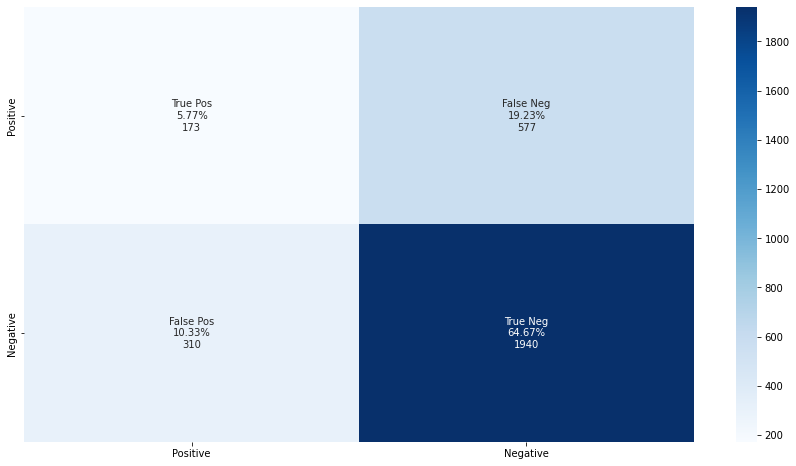

In [120]:
predict, original = [], []
for x, y in valloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        optimizer.zero_grad()
        y_hat = model(x)
        predict.extend(torch.argmax(y_hat, dim=1).cpu())
        original.extend(torch.argmax(y, dim=1).cpu())

show_result2group(['Negative' if int(x) == 1 else 'Positive' for x in predict], ['Negative' if int(x) == 1 else 'Positive' for x in original])

In [ ]:
# Performance looks quite bad, will try to explore embedding from raw text instead of processed text
# & processed text without embedding